# Transformed Density Rejection (TDR) demo

This notebook showcases SciPy's `scipy.stats.sampling.TransformedDensityRejection` (TDR) sampler.

We will:
- Define a standard normal distribution via `pdf` and `dpdf`.
- Construct a TDR sampler and draw samples.
- Compare the sample histogram to the true PDF.
- Inspect diagnostic attributes like `squeeze_hat_ratio`.
- Compare `ppf_hat` to the normal distribution's PPF.
- Show truncation via the `domain` argument and the impact of `max_squeeze_hat_ratio`.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats.sampling import TransformedDensityRejection

# Reproducible RNGs
urng = np.random.default_rng(123)

## Define the target distribution
TDR expects a Python object with scalar `pdf(x)` and `dpdf(x)` methods (and optional `support()`).
The PDF need not be normalized. Here we use the standard normal density (up to normalization).

In [2]:
class StandardNormal:
    def pdf(self, x: float) -> float:
        # exp(-x^2 / 2) — normalization constant is not required for TDR
        return float(np.exp(-0.5 * x * x))

    def dpdf(self, x: float) -> float:
        # derivative w.r.t. x
        return float(-x * np.exp(-0.5 * x * x))

    def support(self):
        return (-np.inf, np.inf)


dist = StandardNormal()
rng_tdr = TransformedDensityRejection(dist, mode=0.0, random_state=urng)
rng_tdr

## Draw samples and compare with the true PDF
We draw samples and overlay the histogram with the true standard normal PDF for reference.

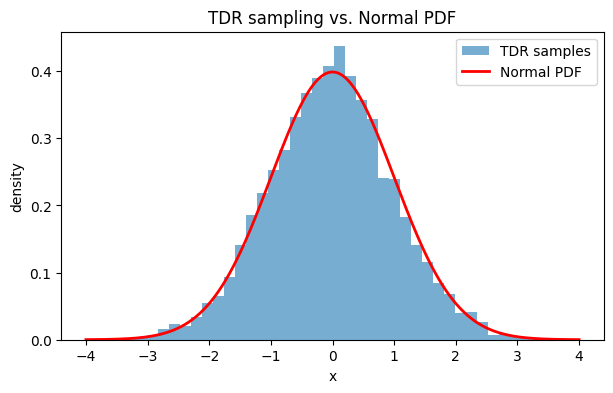

In [3]:
n = 5000
samples = rng_tdr.rvs(size=n)

xs = np.linspace(-4, 4, 400)
true_pdf = norm.pdf(xs)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(samples, bins=40, density=True, alpha=0.6, label="TDR samples")
ax.plot(xs, true_pdf, "r-", lw=2, label="Normal PDF")
ax.set_xlabel("x")
ax.set_ylabel("density")
ax.set_title("TDR sampling vs. Normal PDF")
ax.legend();

## Diagnostics: squeeze-hat ratio and areas
Higher `squeeze_hat_ratio` (closer to 1) implies fewer PDF evaluations during sampling.

In [4]:
ratio = rng_tdr.squeeze_hat_ratio
hat = rng_tdr.hat_area
squeeze = rng_tdr.squeeze_area
ratio_check = squeeze / hat
print(f"squeeze_hat_ratio = {ratio:.6f}")
print(f"hat_area          = {hat:.6f}")
print(f"squeeze_area      = {squeeze:.6f}")
print(f"consistency       = {abs(ratio - ratio_check) < 1e-12}")

squeeze_hat_ratio = 0.994723
hat_area          = 2.510220
squeeze_area      = 2.496973
consistency       = True


## PPF-hat accuracy check
Compare `rng_tdr.ppf_hat(u)` to the normal distribution's `ppf(u)`.

In [5]:
u = np.linspace(0.0, 1.0, 21)
ppf_hat = rng_tdr.ppf_hat(u)
ppf_true = norm.ppf(u)
# Ignore +/- inf at the edges
mask = np.isfinite(ppf_true) & np.isfinite(ppf_hat)
max_abs_err = np.max(np.abs(ppf_hat[mask] - ppf_true[mask]))
print(f"max |ppf_hat - ppf_true| over finite u = {max_abs_err:.6e}")

max |ppf_hat - ppf_true| over finite u = 2.723840e-03


## Truncation via `domain`
We can truncate the distribution to, say, the positive reals by passing `domain=[0, np.inf]`.

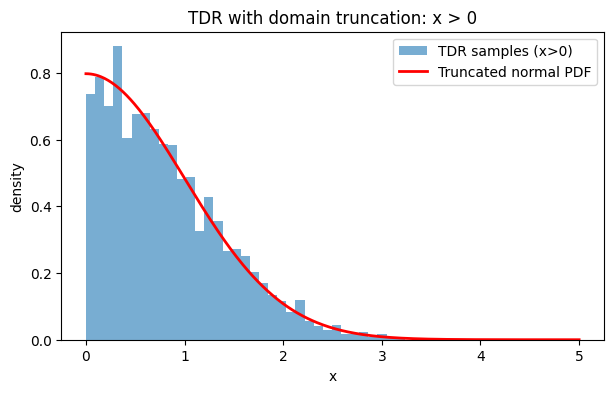

In [6]:
urng2 = np.random.default_rng(321)
rng_pos = TransformedDensityRejection(dist, domain=[0.0, np.inf], random_state=urng2)
s_pos = rng_pos.rvs(size=4000)

xs = np.linspace(0, 5, 400)
# Truncated normal to x>0
Z = 1 - norm.cdf(0.0)
true_pdf_trunc = norm.pdf(xs) / Z

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(s_pos, bins=40, density=True, alpha=0.6, label="TDR samples (x>0)")
ax.plot(xs, true_pdf_trunc, "r-", lw=2, label="Truncated normal PDF")
ax.set_xlabel("x")
ax.set_ylabel("density")
ax.set_title("TDR with domain truncation: x > 0")
ax.legend();

## Effect of `max_squeeze_hat_ratio` on work
Larger values increase setup cost but reduce PDF evaluations during sampling.

In [7]:
from copy import copy


class StandardNormalWithCallbacks(StandardNormal):
    def __init__(self):
        self.callbacks = 0

    def pdf(self, x: float) -> float:
        self.callbacks += 1
        return super().pdf(x)


# Use identical uniform streams for fairness
base_urng = np.random.default_rng(2024)
urng_a = copy(base_urng)
urng_b = copy(base_urng)

dist_a = StandardNormalWithCallbacks()
dist_b = StandardNormalWithCallbacks()
rng_a = TransformedDensityRejection(dist_a, random_state=urng_a)
rng_b = TransformedDensityRejection(
    dist_b, max_squeeze_hat_ratio=0.999, random_state=urng_b
)

# Ignore setup callbacks, compare sampling
dist_a.callbacks = 0
dist_b.callbacks = 0
_ = rng_a.rvs(size=20000)
_ = rng_b.rvs(size=20000)
print("PDF calls during sampling:")
print("  default max_squeeze_hat_ratio:", dist_a.callbacks)
print("  0.999 max_squeeze_hat_ratio :", dist_b.callbacks)

PDF calls during sampling:
  default max_squeeze_hat_ratio: 116
  0.999 max_squeeze_hat_ratio : 14


In [8]:
%load_ext watermark

In [10]:
%watermark -a "Carsten Jørgensen" -u -d -v -m  --iversions

Author: Carsten Jørgensen

Last updated: 2025-08-17

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

Compiler    : Clang 17.0.0 (clang-1700.0.13.3)
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 11
Architecture: 64bit

numpy     : 2.2.6
scipy     : 1.16.1
matplotlib: 3.10.5



---
References:
- SciPy docs: `scipy.stats.sampling.TransformedDensityRejection`
- Hörmann, Wolfgang. “A rejection technique for sampling from T-concave distributions.” ACM Transactions on Mathematical Software (TOMS) 21.2 (1995): 182-193